In [29]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from syd import make_viewer

from sklearn.decomposition import PCA
from umap import UMAP

from vrAnalysis2.helpers import Timer, tic, toc, nearestpoint
from vrAnalysis2.sessions import create_b2session
from vrAnalysis2.processors.spkmaps import SpkmapProcessor, SpkmapParams
from vrAnalysis2.tracking import Tracker
from vrAnalysis2.multisession import MultiSessionSpkmaps

mouse_name = "ATL027"
date = "2023-07-27"
session_id = "701"
spks_type = "significant"

session = create_b2session(mouse_name, date, session_id, dict(spks_type=spks_type))
smp = SpkmapProcessor(session)0

In [30]:
# Converting session.vrExperiment.get_frame_behavior to vrAnalysis2

# timestamps = behaveTimeStamps
# positions = behavePosition
# trial_numbers = behaveTrialIdx
# idx_behave_to_frame = camelCase
timestamps, positions, trial_numbers, idx_behave_to_frame = session.positions
environment_sample = session.loadone("trials.environmentIndex")[trial_numbers]
within_trial_sample = np.append(np.diff(trial_numbers)==0, True)

sample_duration = np.append(np.diff(timestamps), 0)
speeds = np.append(np.diff(positions) / sample_duration[:-1], 0)
sample_duration = sample_duration * within_trial_sample
speeds = speeds * within_trial_sample

imaging_timestamps = session.timestamps
dist_behave_to_imaging = np.abs(timestamps - imaging_timestamps[idx_behave_to_frame])
sampling_period = np.median(np.diff(imaging_timestamps))
dist_cutoff = sampling_period / 2

idx_imaging_to_behave, dist_imaging_to_behave = nearestpoint(imaging_timestamps, timestamps)
idx_get_position = dist_imaging_to_behave < dist_cutoff

imaging_position = np.full(len(imaging_timestamps), np.nan)
count = np.zeros_like(imaging_timestamps)

# NUMBA STUFF TO AVERAGE

imaging_speed = np.full(len(imaging_timestamps), np.nan)
count = np.zeros_like(imaging_timestamps)

# NUMBA STUFF TO AVERAGE

imaging_environment = np.full(len(imaging_timestamps), np.nan)
imaging_environment[idx_get_position] = environment_sample[idx_imaging_to_behave[idx_get_position]]


In [28]:
timestamps.shape, positions.shape, trial_numbers.shape, idx_behave_to_frame.shape, environment_sample.shape, max(idx_behave_to_frame)

((24976,), (24976,), (24976,), (24976,), (24976,), 12366)

In [ ]:
    # ------------------- convert between imaging and behavioral time -------------------
    def get_frame_behavior(self, speedThreshold=5, use_average=True, return_speed=False):
        """
        get position and environment data for each frame in imaging data
        nan if no position data is available for that frame (e.g. if the closest
        behavioral sample is further away in time than the sampling period)
        """
        # convert position data to mpcis
        trialStartSample = self.loadone("trials.positionTracking")
        environmentIndex = self.loadone("trials.environmentIndex")
        behaveTimeStamps = self.loadone("positionTracking.times")  # times of position tracking
        behavePosition = self.loadone("positionTracking.position")  # position for position tracking
        idxBehaveToFrame = self.loadone("positionTracking.mpci")
        behaveTrialIdx = self.getBehaveTrialIdx(trialStartSample)  # array of trial index for each sample
        behaveEnvironment = environmentIndex[behaveTrialIdx]  # environment for each sample

        # only true if next sample is from same trial (last sample from each trial == False)
        withinTrialSample = np.append(np.diff(behaveTrialIdx) == 0, True)

        # time between samples, assume zero time was spent in last sample for each trial
        sampleDuration = np.append(np.diff(behaveTimeStamps), 0)
        # speed in each sample, assume speed was zero in last sample for each trial
        behaveSpeed = np.append(np.diff(behavePosition) / sampleDuration[:-1], 0)
        # keep sample duration when speed above threshold and sample within trial
        sampleDuration = sampleDuration * withinTrialSample
        # keep speed when above threshold and sample within trial
        behaveSpeed = behaveSpeed * withinTrialSample

        frameTimeStamps = self.loadone("mpci.times")  # timestamps for each imaging frame
        distBehaveToFrame = np.abs(behaveTimeStamps - frameTimeStamps[idxBehaveToFrame])
        sampling_period = np.median(np.diff(frameTimeStamps))
        distCutoff = sampling_period / 2  # (time) of cutoff for associating imaging frame with behavioral frame

        idxFrameToBehave, distFrameToBehave = helpers.nearestpoint(frameTimeStamps, behaveTimeStamps)
        idx_get_position = distFrameToBehave < distCutoff
        if use_average:
            frame_position = np.zeros_like(frameTimeStamps)
            count = np.zeros_like(frameTimeStamps)
            helpers.getAverageFramePosition(
                behavePosition,
                behaveSpeed,
                speedThreshold,
                idxBehaveToFrame,
                distBehaveToFrame,
                distCutoff,
                frame_position,
                count,
            )
            frame_position[count > 0] /= count[count > 0]
            frame_position[count == 0] = np.nan
            if return_speed:
                frame_speed = np.zeros_like(frameTimeStamps)
                count_speed = np.zeros_like(frameTimeStamps)
                helpers.getAverageFrameSpeed(
                    behaveSpeed,
                    speedThreshold,
                    idxBehaveToFrame,
                    distBehaveToFrame,
                    distCutoff,
                    frame_speed,
                    count_speed,
                )
                frame_speed[count_speed > 0] /= count_speed[count_speed > 0]
                frame_speed[count_speed == 0] = np.nan
        else:
            frame_position = np.full(len(frameTimeStamps), np.nan)
            frame_position[idx_get_position] = behavePosition[idxFrameToBehave[idx_get_position]]
            if return_speed:
                frame_speed = np.full(len(frameTimeStamps), np.nan)
                frame_speed[idx_get_position] = behaveSpeed[idxFrameToBehave[idx_get_position]]

        frame_environment = np.full(len(frameTimeStamps), np.nan)
        frame_environment[idx_get_position] = behaveEnvironment[idxFrameToBehave[idx_get_position]]

        if return_speed:
            return frame_position, frame_environment, np.unique(environmentIndex), frame_speed

        return frame_position, frame_environment, np.unique(environmentIndex)

In [23]:
session.print_saved_one()

['licks.times',
 'licksTracking.positionTracking',
 'mpci.roiActivityDeconvolved',
 'mpci.roiActivityDeconvolvedOasis',
 'mpci.roiActivityF',
 'mpci.roiNeuropilActivityF',
 'mpci.times',
 'mpciROIs.bestInCluster',
 'mpciROIs.isCell',
 'mpciROIs.redCellIdx',
 'mpciROIs.redCellIdxCoherent',
 'mpciROIs.redCellManualAssignments',
 'mpciROIs.redDotProduct',
 'mpciROIs.redPearson',
 'mpciROIs.redPhaseCorrelation',
 'mpciROIs.redS2P',
 'mpciROIs.redundant',
 'mpciROIs.stackPosition',
 'parametersRedDotProduct.keyValuePairs',
 'parametersRedDotProduct.minMaxCutoff',
 'parametersRedPearson.keyValuePairs',
 'parametersRedPearson.minMaxCutoff',
 'parametersRedPhaseCorrelation.keyValuePairs',
 'parametersRedPhaseCorrelation.minMaxCutoff',
 'parametersRedS2P.minMaxCutoff',
 'positionTracking.mpci',
 'positionTracking.position',
 'positionTracking.times',
 'rewards.times',
 'trials.activeLicking',
 'trials.activeStopping',
 'trials.environmentIndex',
 'trials.movementGain',
 'trials.positionTracking

In [21]:
spks = session.spks[:, session.idx_rois]
spkmap = smp.get_env_maps(use_session_filters=True)
spkmap.pop_nan_positions()
print(spkmap)
print([s.shape for s in spkmap.spkmap])
print(spks.shape)

spkmap_samples = np.concatenate(([s.reshape(s.shape[0], -1) for s in spkmap.spkmap]), axis=1).T
environment_index = np.concatenate(([ienv * np.ones(np.prod(s.shape[1:])) for ienv, s in enumerate(spkmap.spkmap)]), axis=0)
print(spkmap_samples.shape, spks.shape, environment_index.shape)

n_neighbors = 15
n_components = 2
umap_spks = UMAP(n_neighbors=n_neighbors, n_components=n_components).fit(spks)
umap_maps = UMAP(n_neighbors=n_neighbors, n_components=n_components).fit(spkmap_samples)

pca_spks = PCA(n_components=n_components).fit(spks)
pca_maps = PCA(n_components=n_components).fit(spkmap_samples)

Maps(num_trials={45, 53}, num_positions=195, num_rois=7215, environments={1, 3}, rois_first=True)
[(7215, 45, 195), (7215, 53, 195)]
(12367, 7215)
(19110, 7215) (12367, 7215) (19110,)


c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Andrew\AppData\Local\miniforge3\envs\vrAnalysis\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [11]:
pc_spks = pca_spks.transform(spks)
pc_maps = pca_maps.transform(spkmap_samples)

emb_spks = umap_spks.embedding_
emb_maps = umap_maps.embedding_
# emb_spks_from_maps = umap_maps.transform(spks)
# emb_maps_from_spks = umap_spks.transform(spkmap_samples)

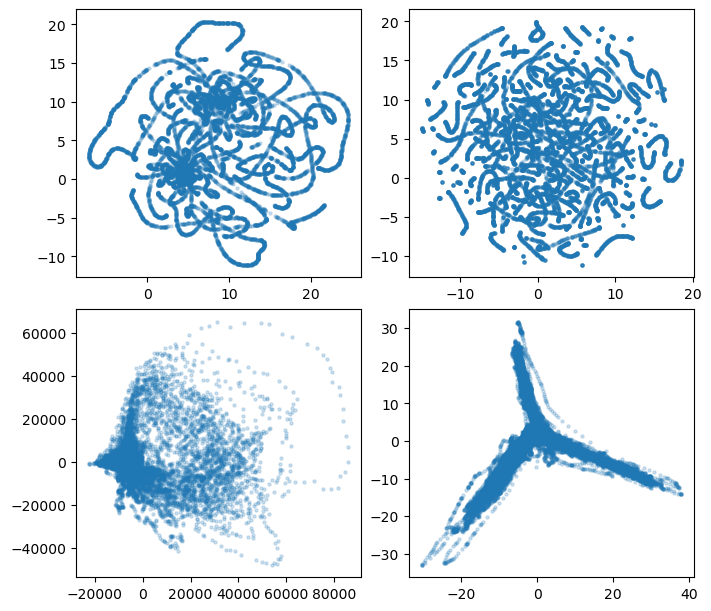

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(7, 6), layout="constrained")
ax[0, 0].scatter(emb_spks[:, 0], emb_spks[:, 1], s=5, alpha=0.2)
ax[0, 1].scatter(emb_maps[:, 0], emb_maps[:, 1], s=5, alpha=0.2)
ax[1, 0].scatter(pc_spks[:, 0], pc_spks[:, 1], s=5, alpha=0.2)
ax[1, 1].scatter(pc_maps[:, 0], pc_maps[:, 1], s=5, alpha=0.2)
plt.show()